# Tutorial
This is a very basic tutorial of segmentation and reconstruction in SEM.  Here, we use a simple 2-d embedding space as it is easy to visualize.  For the purpose of this tutorial, we do not consider structured embedding space (the HRR).

In [1]:
# # un-comment out if running locally

# import os
# os.chdir('../')

In [2]:
# # ## if running locally, comment out the following code

!git clone https://github.com/nicktfranklin/SEM2.git
import os
os.chdir('./SEM3/')



In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from core.sem import SEM
from sklearn import metrics
sns.set_context('talk')

TensorFlow Version: 2.1.0


Here, we create a toy data set: 2 events, both linear systems in a simple 2-D space with different ammounts of noise

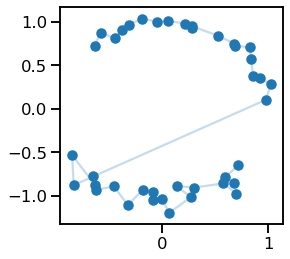

In [4]:
np.random.seed(0)  # for consistency, set the seed

def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

A = rotation_matrix( -np.pi/2 * 0.075)
x_train = [ np.array([[-1, 1]]).T / np.sqrt(2)]

for _ in range(19):
    x_train.append(np.matmul(A, x_train[-1]))
    


A = rotation_matrix( np.pi/2 * 0.055)
x_train.append(np.array([[-1, -1]]).T / np.sqrt(2))
for _ in range(19):
    x_train.append(np.matmul(A, x_train[-1]))

x_train = np.concatenate(x_train, axis=1).T


# add observation noise
x_train[:20, :] += np.random.randn(20, 2) * 0.04
x_train[20:, :] += np.random.randn(20, 2) * 0.12

plt.figure(figsize=(4,4))
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.plot(x_train[:, 0], x_train[:, 1], alpha=0.25)

# label of the true identies
y = np.concatenate([np.zeros(20), np.ones(20)])

# Segmentation
Below, we set the parameters for segmentation.  We generally only need to change the sticky-CRP parameters and the prior variance of the event model.  The rest is set behind the scenes.  Of the two, the prior variance is typically the most imporant

In [5]:
lmda = 0.1  # stickyness parameter
alfa = 1.0  # concentration parameter

# These are parameters of the event model, not SEM, 
# and they are stored in a seperate dictionary
f_opts = dict(n_epochs=15)

# store all of the SEM parameters and the event model parameters in a dictionary
sem_kwargs = dict(lmda=lmda, alfa=alfa, f_opts=f_opts)


In [6]:
## uncomment to see the documentation for the SEM object
# help(SEM)

In [7]:
# run segmentation
sem_model = SEM(**sem_kwargs)
post = sem_model.run(x_train)

Run SEM: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s]


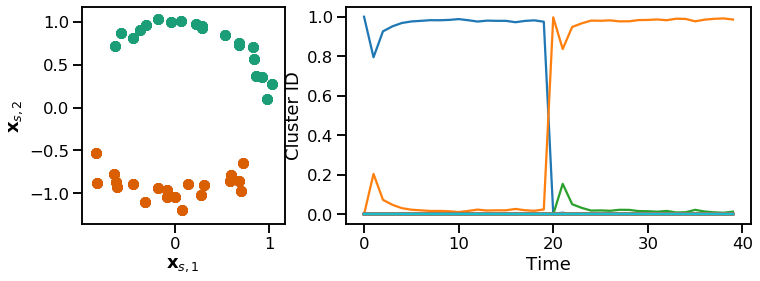

In [8]:
# plot results
def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
plot_segmentation(post, y)

In [9]:
y_hat = np.argmax(post, axis=1)
print("Adjusted Rand Score: {}\n".format(metrics.adjusted_rand_score(y, y_hat))) 
print(y_hat)

Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


# Memory
----

Now, we move on to some simple demonstrations of memory smoothing

## Created corrupted memory trace
The software has a buildin function for generating corrupted memory traces consistent with the model 

In [10]:
from core.memory import create_corrupted_trace
help(create_corrupted_trace)

Help on function create_corrupted_trace in module core.memory:

create_corrupted_trace(x, e, tau, epsilon_e, b, return_random_draws_of_p_e=False)
    create a corrupted memory trace from feature vectors and event labels
    
    :param x:           np.array of size nXd, featur vectors
    :param e:           np.array of length n, event labels
    :param tau:         float, feature corruption
    :param epsilon_e:   float, event label precision
    :param b:           int, time index corruption
    
    :return y_mem: list of corrupted memory tuples:



In [11]:
epsilon_e = 0.1 # event label precision (1 - zero/one loss probability)
tau = 0.08 # feature corruption noise (Guassian)
b = 2 # temporal corruption noise (uniform)
noise_kwargs = dict(tau=tau, epsilon_e=epsilon_e, b=b)

e_true = y_hat # event labels as expereinced by SEM
y_mem = create_corrupted_trace(x_train, e_true, **noise_kwargs)

This is a list of corrupted memory traces. Each trace is a tuple, containing
1. a corrupted set of features,
2. a corrupted event label, and 
3. a corrupted time index

In [12]:
y_mem[:5]

[[array([-0.93663717,  1.21840953]), None, -1],
 [array([-0.13406432,  1.25319536]), None, -1],
 [array([0.02391177, 1.01386824]), None, 2],
 [array([-0.48955435,  1.04141966]), None, 1],
 [array([-0.16004329,  0.63624963]), None, 3]]

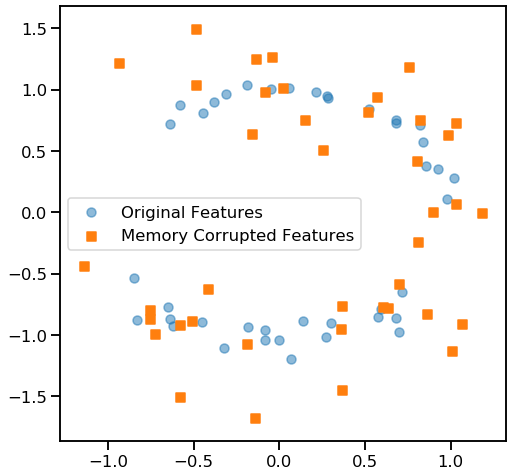

In [13]:
# plot the corrupted features
x_mem = np.concatenate([y_mem0[0].reshape(1, -1) for y_mem0 in y_mem])
# plt.plot()
plt.figure(figsize=(8,8))
plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.5, label='Original Features')
plt.scatter(x_mem[:, 0], x_mem[:, 1], marker='s', label='Memory Corrupted Features')
plt.legend()

## Reconstruction
As before, there is a function in the memory module to perform reconstruction.  We just need to set parameters

In [14]:
from core.memory import gibbs_memory_sampler
help(gibbs_memory_sampler)

Help on function gibbs_memory_sampler in module core.memory:

gibbs_memory_sampler(y_mem, sem_model, memory_alpha, memory_lambda, memory_epsilon, b, tau, n_samples=100, n_burnin=25, progress_bar=True, leave_progress_bar=True)
    :param y_mem: list of 3-tuples (x_mem, e_mem, t_mem), corrupted memory trace
    :param sem_mdoel: trained SEM instance
    :param memory_alpha: SEM alpha parameter to use in reconstruction
    :param memory_labmda: SEM lmbda parameter to use in reconstruction
    :param memory_epsilon: (float) parameter controlling propensity to include null trace in reconstruction
    :param b: (int) time index corruption noise
    :param tau: (float, greater than zero) feature vector corruption noise
    :param n_burnin: (int, default 25) number of Gibbs sampling itterations to burn in
    :param n_samples: (int, default 100) number of Gibbs sampling itterations to collect
    :param progress_bar: (bool) use progress bar for sampling?
    :param leave_progress_bar: (bool, d

In [15]:
gibbs_memory_kwargs = dict(
    y_mem=y_mem, sem_model=sem_model,
    memory_alpha = sem_kwargs['alfa'],
    memory_lambda = sem_kwargs['lmda'],
    memory_epsilon = np.exp(-10),
    b = noise_kwargs['b'],
    tau = noise_kwargs['tau'],
)

y_samp, e_samp, x_samp = gibbs_memory_sampler(**gibbs_memory_kwargs)

Gibbs Sampler: 100%|██████████| 125/125 [04:57<00:00,  2.38s/it]


In [16]:
from core.memory import reconstruction_accuracy, evaluate_seg

print("total reconstruction accuracy: {}".format(reconstruction_accuracy(y_samp, y_mem).mean()))
# this metric evaluates the proportion of time each memory trace is included in the sample.
# It is a useful diagnositic and sometimes useful to think of this as recall.

print("reconstruction segmentation: {}".format(evaluate_seg(e_samp, e_true)))
## How well the memory model recovered the segmentation is also a useful diagnostic

total reconstruction accuracy: 0.867
reconstruction segmentation: 0.8715


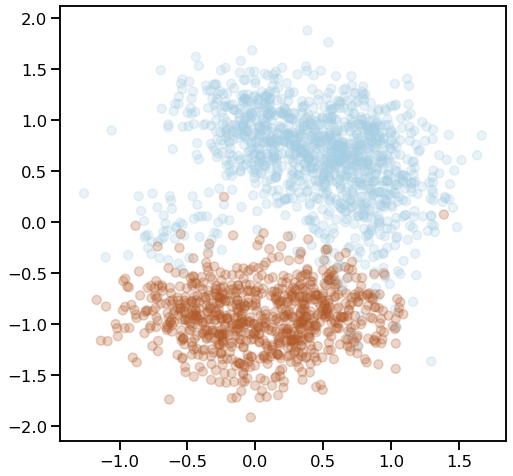

In [17]:
plt.figure(figsize=(8,8))


for ii in range(50):
    plt.scatter(x_samp[ii][:, 0], x_samp[ii][:, 1], alpha=0.25, c=e_samp[ii], cmap='Paired')

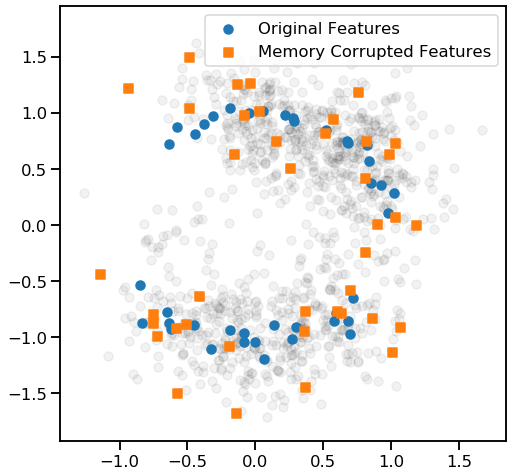

In [18]:
plt.figure(figsize=(8,8))

for ii in range(25):
    plt.scatter(x_samp[ii][:, 0], x_samp[ii][:, 1], alpha=0.05, c='k')

plt.scatter(x_train[:, 0], x_train[:, 1], label='Original Features')
plt.scatter(x_mem[:, 0], x_mem[:, 1], marker='s', label='Memory Corrupted Features')
plt.legend()

## Comparison to a Hidden Markov Model (HMM)

We can also compare SEM to a reduced model that infers events but does not learn event dynamics (a.k.a. a Hidden Markov Model). These models typically do well in segmentation, but are less often used as memory models (to our knoweldge).

In [19]:
from core.event_models import StationaryEvent

# copy the original segementation parameters and change the event model class to
# a stationary emmision distribution
hmm_kwargs = {k: v for k, v in sem_kwargs.items()}
hmm_kwargs['f_class'] = StationaryEvent

hmm_model = SEM(**hmm_kwargs)
post = hmm_model.run(x_train)
y_hat_hmm = np.argmax(post, axis=1)
print("Adjusted Rand Score: {}\n".format(metrics.adjusted_rand_score(y, y_hat_hmm)))

# copy the gibbs parameters and just update the model
gibbs_memory_kwargs_hmm = {k: v for k, v in gibbs_memory_kwargs.items()}
gibbs_memory_kwargs_hmm['sem_model'] = hmm_model

y_samp_hmm, e_samp_hmm, x_samp_hmm = gibbs_memory_sampler(**gibbs_memory_kwargs_hmm)


Run SEM: 100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Adjusted Rand Score: 0.00025828113901978637



Gibbs Sampler: 100%|██████████| 125/125 [06:28<00:00,  3.11s/it]


The HMM does a good job of segmentation but how good is it as a memory model? We can compare the reconstructed scenes for both SEM and the HMM by comparing the distribution of distances between the original scenes and the reconstructed equivalents.  

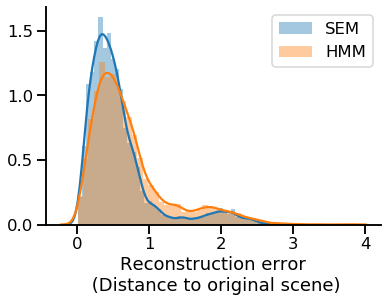

In [20]:
def get_dist(a, b):
    return np.linalg.norm(a - b, axis=1)

sns.distplot(np.concatenate([get_dist(x0, x_train) for x0 in x_samp]), label='SEM')
sns.distplot(np.concatenate([get_dist(x0, x_train) for x0 in x_samp_hmm]), label='HMM')
plt.xlabel('Reconstruction error\n (Distance to original scene)')
plt.legend()
sns.despine()

A key prediction of SEM is that memory traces are regularized towards the event dynamics, and not towards a global average of all scenes within an event. 

To calculate this, we get the distance between:
1. each reconstructed feature and both the the original scene
2. each reconstructed feature and the average scene with the (inferred) event.

In this dataset, these two distance metrics are co-linear.

If (1) is greater than (2), then the model as regularized towards the event trajectory.  If (2) is greater than (1), then the model has regularized towards the centroid.  For simplicity, we just plot the relative difference between these two here, with a postive value indicating regularization towards the original scene and a negative value indicating regularization towards the centroid.


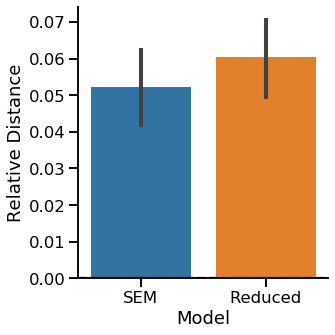

In [21]:
import pandas as pd
event_centroids = np.concatenate([
    np.tile(x_train[e_true == 0, :].mean(axis=0), (20, 1)),
    np.tile(x_train[e_true == 1, :].mean(axis=0), (20, 1))
])

sem_reld = np.concatenate([-get_dist(x0, x_train) + get_dist(x0, event_centroids) for x0 in x_samp])
red_reld = np.concatenate([-get_dist(x0, x_train) + get_dist(x0, event_centroids) for x0 in x_samp_hmm])

df = pd.DataFrame(
    {
        'Model': ['SEM'] * len(sem_reld) + ['Reduced'] * len(red_reld),
        'Relative Distance': np.concatenate([sem_reld, red_reld])
    })
sns.catplot(data=df, x='Model', y='Relative Distance', kind='bar')
plt.axhline(y=0, ls='--', c='k')

As we can see, SEM regularizes towards the memory trace and the HMM regularizes toward the avewrage scene